In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly
plotly.offline.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [11]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [12]:
df = pd.read_csv('../../data/banking_transactions_output_data/scaled_df_v2.csv')
# df = pd.read_csv('scaled_df.csv')
df.head()

,creditSpendtoLimitRatio,averageMonthlySpending,numTnxMonthlyAverage,numAccounts,incomeToSavingsRanking
0,0.500000,0.666667,0.000000,0.000000,0.50
1,0.383667,0.590073,0.216667,1.000000,0.75
2,0.579173,0.666667,0.000000,0.666667,0.25
3,1.000000,0.639782,0.387500,1.000000,0.25
4,0.933909,0.337292,0.450000,1.000000,0.25


In [13]:
X = df

## Clustering with DBSCAN

In [14]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=5)
db.fit(X) #algorithm runs

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
#core_samples_mask will be True if the data point was a core point. Otherwise false.

labels = db.labels_
#actual cluster label. If outliers, gets assigned -1

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) #number of unique clusters labels (excluding -1)
n_noise_ = list(labels).count(-1) #counts how many outliers there are (labels with -1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 12


## Visualizing with Radial Plot

In [15]:
# visualize the clusters by drawing radial plots of their centroids
import plotly.graph_objects as go

# find the centroids of the clusters by calculating the mean
# across the features

df_with_cluster_labels = df.copy()
df_with_cluster_labels['cluster'] = labels

cluster_means = []
for c in set(labels):
    mean = df_with_cluster_labels[df_with_cluster_labels['cluster'] == c].mean()
    mean.drop(labels='cluster', inplace=True)
    cluster_means.append(mean)
pd.DataFrame(cluster_means) # to view in a dataframe

,creditSpendtoLimitRatio,averageMonthlySpending,numTnxMonthlyAverage,numAccounts,incomeToSavingsRanking
0,0.500000,0.666667,0.000000,0.000000,0.500000
1,0.483836,0.580768,0.393522,1.000000,0.476695
2,0.490227,0.599611,0.330414,0.666667,0.482510
3,0.492186,0.624831,0.173093,0.333333,0.482659
4,0.449982,0.564613,0.840000,0.833333,0.562500


In [16]:
import plotly.graph_objects as go
# looping through each cluster to draw the radial plot
for i, cluster in enumerate(cluster_means):
    
    columns = list(cluster.index)
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
          r=list(cluster.values),
          theta=columns,
          fill='toself',
          name='Cluster ' + str(i)
    ))


    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
      showlegend=True
    )

    fig.show()

## PCA for visualization

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
df_pca = pca.fit(df)
df_pca

PCA()

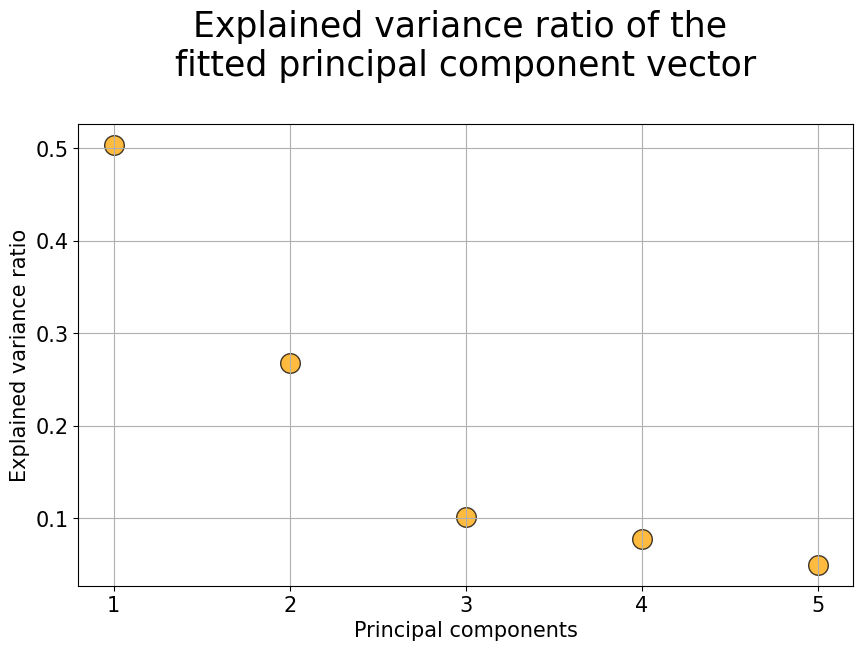

In [18]:
# Expanded variance ratio

plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_pca.explained_variance_ratio_))],
            y=df_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

## Visualizing cluster separation

In [19]:
# applying DBSCAN to PCA
X = pca.transform(df)
db = DBSCAN(eps=0.3, min_samples=5)
db.fit(X) #algorithm runs
labels = db.labels_

In [20]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) #number of unique clusters labels (excluding -1)
n_noise_ = list(labels).count(-1) #counts how many outliers there are (labels with -1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 12


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


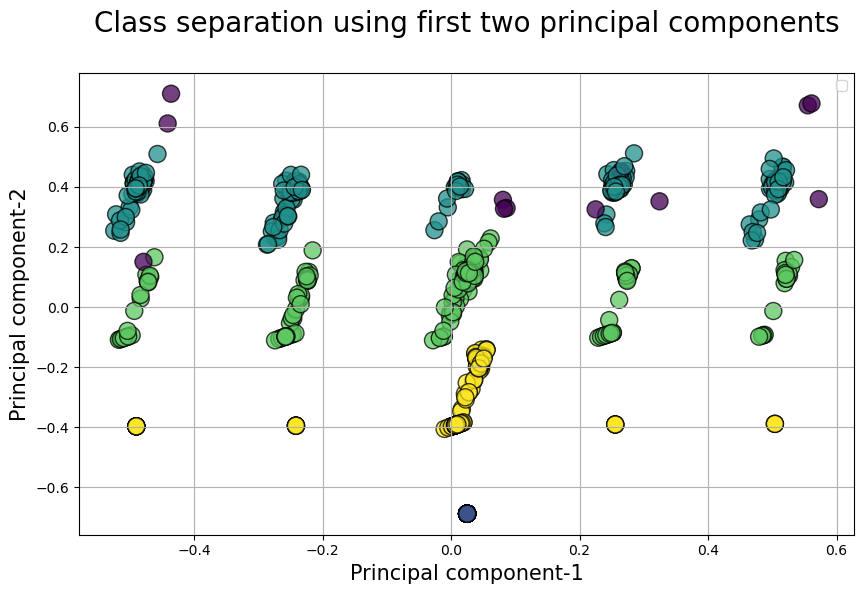

In [21]:
# transform the X dataframe with PCA and then
# plot the scatter diagram

df_trans = pca.transform(df)
df_trans = pd.DataFrame(data=df_trans)

plt.figure(figsize=(10,6))
plt.scatter(df_trans[1],df_trans[0],c=labels,edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.legend()
plt.show()
